In [1]:
# Setup
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/florian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/florian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Suppression de l'affichage des messages d'avertissement
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importation des données et affichage du format
debats_df = pd.read_csv('https://matthiasfoyer.com/tmp/debats.csv')
debats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65603 entries, 0 to 65602
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        65603 non-null  int64 
 1   dateSeance        65603 non-null  int64 
 2   texte             65595 non-null  object
 3   groupe_politique  53567 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.0+ MB


In [4]:
# Aperçu des données
debats_df.loc[250:259]

Unnamed: 0         dateSeance  \
250         250  20171214093000000   
251         251  20171214093000000   
252         252  20171214093000000   
253         253  20171214093000000   
254         254  20171214093000000   
255         255  20171214093000000   
256         256  20180418213000000   
257         257  20180418213000000   
258         258  20180418213000000   
259         259  20180418213000000   

                                                 texte groupe_politique  
250  Une fois n’est pas coutume, je suis en profond...              SOC  
251                         Oui, madame la présidente.              NaN  
252  Nous sommes tous favorables à ce qu’il puisse ...               LR  
253  Je tiens à faire part de la gêne que suscite e...              NaN  
254  Madame la ministre, je vous remercie pour votr...            UDI-I  
255                     Vous pouvez compter sur nous !               LR  
256  Prochaine séance, aujourd’hui, à neuf heures t...              Dem  
257  \n            \nLa Directrice du service du co...              NaN  
258  Restez donc jusqu’à ce que nous y arrivions, c...               FI  
259  Je souhaiterais que vous nous donniez un chiff...               FI

In [5]:
# Suppression des colonnes inutiles
debats_df.drop(['Unnamed: 0', 'dateSeance'], 1, inplace=True)

# Suppression des lignes comportant des données manquantes
debats_df.dropna(subset = ["groupe_politique"], inplace=True)

# On conserve uniquement les groupes politiques qui nous intéressent (cf. sujet)
debats_df = debats_df[(debats_df.groupe_politique != 'LaREM') & (debats_df.groupe_politique != 'NI') &
                      (debats_df.groupe_politique != 'Dem') & (debats_df.groupe_politique != 'UDI-I') & 
                      (debats_df.groupe_politique != 'LT') & (debats_df.groupe_politique != 'Agir ens')]

# On remplace les groupes politiques par les partis correspondants
debats_df['groupe_politique'] = debats_df['groupe_politique'].replace(['SOC','GDR','FI'],'gauche')
debats_df['groupe_politique'] = debats_df['groupe_politique'].replace(['LR'],'droite')

# Aperçu des données pré-traitées
debats_df

texte groupe_politique
4      Dans cet esprit, pourquoi avoir refusé un chan...           gauche
6      Le pompier qui est dans le coma, ce n’est pas ...           gauche
7                          Vous en savez quelque chose !           gauche
8      Le groupe La France insoumise ne désespère pas...           gauche
9      Le groupe de la Gauche démocrate et républicai...           gauche
...                                                  ...              ...
65595          Tout cela, ce sont des cadeaux à crédit !           gauche
65598                         Merci de votre honnêteté !           droite
65599                                          Mais si !           gauche
65601  Je suis toujours très surpris de voir balayer ...           droite
65602                             Cela n’a rien à voir !           droite

[25832 rows x 2 columns]

In [6]:
# Séparation en X et y
X = debats_df[['texte']]
y = debats_df[['groupe_politique']]
X, y = debats_df[['texte']].fillna(''), debats_df[['groupe_politique']]

# Split en jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
def stem_sentences(sentence):
  stemmer = FrenchStemmer()
    
  # Suppression des caractères seuls
  sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)

  sentence = re.sub(r'\W', ' ', sentence)

  # Suppression des nombres
  sentence = re.sub(" \d+", " ", sentence)

  # Stemmer
  words = sentence.split()
  stemmed_words = [stemmer.stem(word) for word in words]
  return ' '.join(stemmed_words)

In [8]:
# Classe pour sélectionner des colonnes à partir de leur nom
class SingleColumnSelector(BaseEstimator, TransformerMixin):
  def __init__(self, key):
    self.key = key
  
  def fit(self, X, y=None):
    return self
    
  def transform(self, data_dict):
    return data_dict[self.key]

In [9]:
# Fonction de tokenisation qui comprend une étape de stemmer
def split_into_tokens_nltk(desc):
  stemmerized_desc = stem_sentences(desc)
  return word_tokenize(stemmerized_desc)

# Liste des mots vides de NLTK + signes de ponctuation
nltk_stopwords = stopwords.words('french')+list(string.punctuation)

# Objet TfidfVectorizer
DescVectorizer = TfidfVectorizer(tokenizer=split_into_tokens_nltk, 
                                min_df = 2, stop_words=nltk_stopwords,
                                max_df = 0.65, ngram_range = (1, 2),
                                lowercase=True)

# Pipeline spécifique
description_pipeline = make_pipeline(
    SingleColumnSelector(key='texte'),
    DescVectorizer
)

# Application de la pipeline à X_train ('apprentissage' du vocabulaire pour la colonne description)
description_pipeline.fit(X_train)

Pipeline(steps=[('singlecolumnselector', SingleColumnSelector(key='texte')),
                ('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.65, min_df=2, ngram_range=(1, 2),
                                 stop_words=['au', 'aux', 'avec', 'ce', 'ces',
                                             'dans', 'de', 'des', 'du', 'elle',
                                             'en', 'et', 'eux', 'il', 'ils',
                                             'je', 'la', 'le', 'les', 'leur',
                                             'lui', 'ma', 'mais', 'me', 'même',
                                             'mes', 'moi', 'mon', 'ne', 'nos', ...],
                                 tokenizer=<function split_into_tokens_nltk at 0x7fcc70603950>))])

In [10]:
# Nombre de traits
fnames_desc = description_pipeline.named_steps['tfidfvectorizer'].get_feature_names()
print('Nombres de traits extraits à partir de la colonne description :', len(fnames_desc))

Nombres de traits extraits à partir de la colonne description : 139955


In [11]:
# Transformation du X_train selon notre pipeline
res = description_pipeline.transform(X_train)

Baseline
              precision    recall  f1-score   support

      droite       0.50      1.00      0.67     10393
      gauche       0.00      0.00      0.00     10272

    accuracy                           0.50     20665
   macro avg       0.25      0.50      0.33     20665
weighted avg       0.25      0.50      0.34     20665

Mutinomial NB
              precision    recall  f1-score   support

      droite       0.67      0.44      0.53     10393
      gauche       0.58      0.78      0.66     10272

    accuracy                           0.61     20665
   macro avg       0.62      0.61      0.60     20665
weighted avg       0.62      0.61      0.60     20665

LR
              precision    recall  f1-score   support

      droite       0.66      0.69      0.67     10393
      gauche       0.67      0.64      0.65     10272

    accuracy                           0.66     20665
   macro avg       0.66      0.66      0.66     20665
weighted avg       0.66      0.66      0.66     

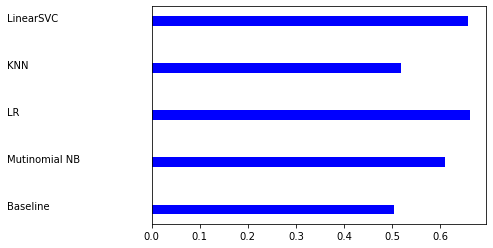

In [12]:
# Modèles à comparer (random forest ecarté pour des raisons de temps d'execution)
models = [
    ('Baseline', DummyClassifier(strategy='most_frequent')),
    ('Mutinomial NB', MultinomialNB()),
    # ('CART', DecisionTreeClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    # ('Random forest', RandomForestClassifier(n_estimators=10)),
    ('LinearSVC', LinearSVC())
]

# Evaluation de chaque résultat
scores = []
names = []
scoring = 'accuracy'

# Validation croisée à 5 plis
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=12)
for name, model in models:
    names.append(name)
    y_pred = model_selection.cross_val_predict(model, res, y_train, cv=kfold)
    print(name)
    print(classification_report(y_train, y_pred))
    acc = metrics.accuracy_score(y_train, y_pred)
    scores.append(acc)

# Représentation graphique
indices = np.arange(len(scores))
fig = plt.figure()
plt.barh(indices, scores, .2, label="score", color='b')
plt.yticks(())
for i, c in zip(indices, names):
    plt.text(-.3, i, c)
plt.show()

In [13]:
# Recherche de paramètres par gridsearch
param_grid = {'C': [0.01, 0.1, 1], 'class_weight': ['balanced', None]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(res, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.66
Best parameters:  {'C': 1, 'class_weight': 'balanced'}
Best estimator:  LogisticRegression(C=1, class_weight='balanced')


In [14]:
# Prétraitement + Définition du modèle LR (meilleur modèle évalué précedemment)
classifier_pipeline = make_pipeline(
    # Préparation des données pour l'apprentissage
    description_pipeline,
    # Algorithme d'apprentissage
    LogisticRegression(C=grid.best_params_['C'], class_weight=grid.best_params_['class_weight'], penalty = 'l2')
)

# Apprentissage avec les données d'entraînement
classifier_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('singlecolumnselector',
                                  SingleColumnSelector(key='texte')),
                                 ('tfidfvectorizer',
                                  TfidfVectorizer(max_df=0.65, min_df=2,
                                                  ngram_range=(1, 2),
                                                  stop_words=['au', 'aux',
                                                              'avec', 'ce',
                                                              'ces', 'dans',
                                                              'de', 'des', 'du',
                                                              'elle', 'en',
                                                              'et', 'eux', 'il',
                                                              'ils', 'je', 'la',
                                                              'le', 'les',
                         

In [15]:
# Test sur des données issues du jeu de test
predicted = classifier_pipeline.predict(X_test.head())
all_predictions = classifier_pipeline.predict(X_test)
print('accuracy', accuracy_score(y_test, all_predictions))

accuracy 0.6644087478227211


In [16]:
# Fonction pour l'affichage de la matrice de confusionn
def make_confusion_matrix(cf, categories='auto', cmap='Blues', title=None):
  # text in heatmap squares
  blanks = ['' for i in range(cf.size)]

  # group parameters
  group_labels = blanks
  group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]

  # box labels
  box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
  box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

  # statistics and text
  accuracy  = np.trace(cf) / float(np.sum(cf))
  stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)

  # figsize
  figsize = plt.rcParams.get('figure.figsize')

  # visualize
  plt.figure(figsize=figsize)
  sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=True,xticklabels=categories,yticklabels=categories)

  # axes labels
  plt.ylabel('True label')
  plt.xlabel('Predicted label' + stats_text)
  
  # title
  if title:
      plt.title(title)

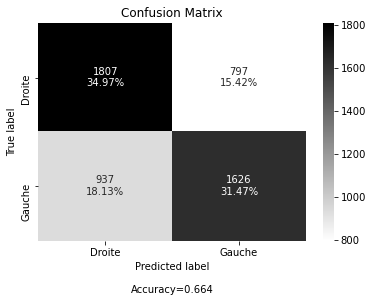

In [17]:
# Matrice de confusion
array_cm = confusion_matrix(y_test,all_predictions)
categories = ['Droite', 'Gauche']
make_confusion_matrix(array_cm, cmap='binary', categories=categories, title='Confusion Matrix')